In [2]:
from surge_multiplier_mdp import mdp_value_iteration as mdp
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
plt.style.use('seaborn-poster')

In [3]:
multipliers = np.arange(1, 8, 0.1)
alphas = np.arange(0, 10, 0.1)

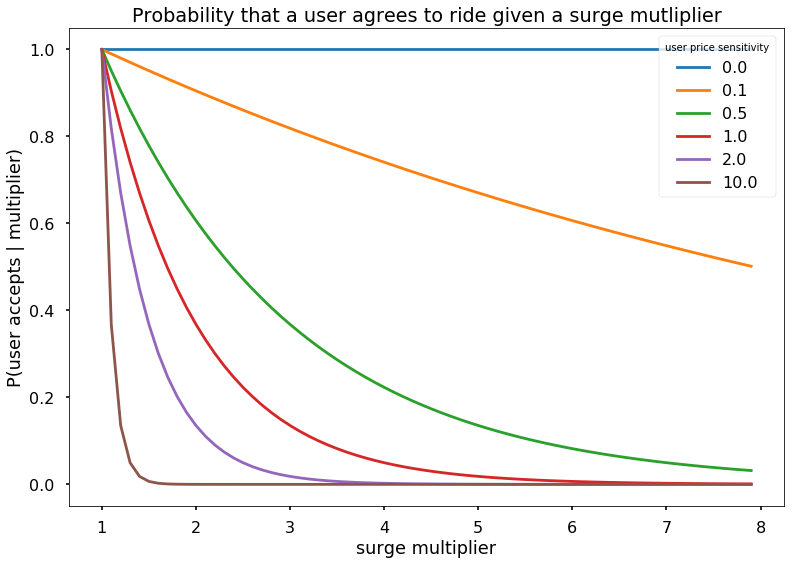

In [4]:
# User acceptance given a multiplier
for a in [0, 0.1, 0.5, 1, 2, 10]:
    p = mdp.acceptance_probability(a, multipliers)
    plt.plot(multipliers, p, label="%0.1f"%a)
plt.legend(loc='upper right', title="user price sensitivity")
plt.ylabel("P(user accepts | multiplier)")
plt.xlabel("surge multiplier")
plt.title("Probability that a user agrees to ride given a surge mutliplier")
None

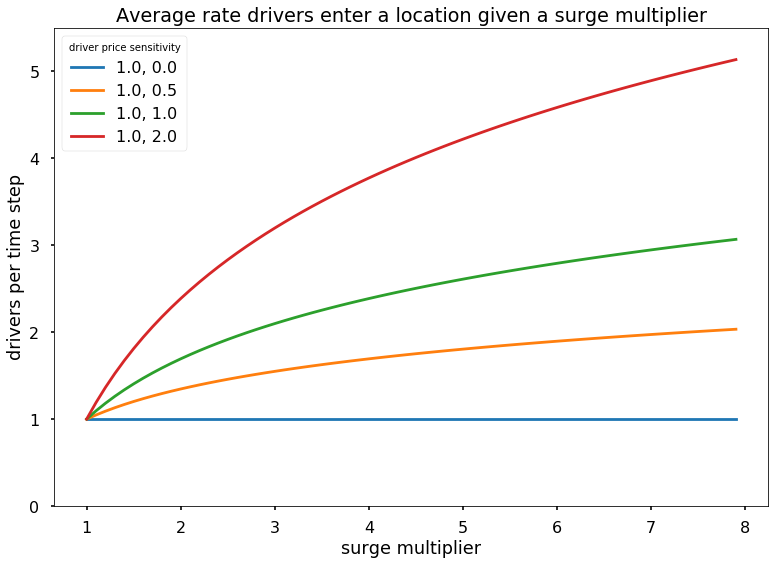

In [5]:
# Driver attraction given a multiplier
for b0, b1 in itertools.product([1.0], [0, 0.5, 1.0, 2.0]):
    n_drivers = mdp.vehicle_in_rate(b0, b1, multipliers)
    plt.plot(multipliers, n_drivers, label="%0.1f, %0.1f" % (b0, b1))
plt.legend(loc='upper left', title="driver price sensitivity")
plt.ylabel("drivers per time step")
plt.xlabel("surge multiplier")
plt.title("Average rate drivers enter a location given a surge multiplier")
plt.ylim([0, 5.5])
None

In [6]:
def errorbar(ax, x, y, yerr, **kw):
    h, = ax.plot(x, y, **kw)
    ax.fill_between(x, y-yerr, y+yerr, alpha=0.5, edgecolor='none', **kw)
    return h

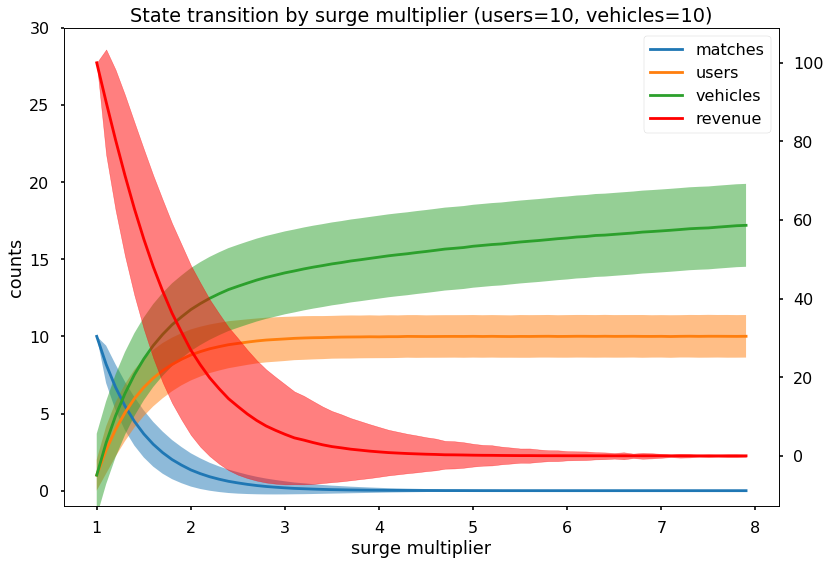

In [7]:
p = mdp.Parameters(
    alpha=2.0,
    beta0=1.0,
    beta1=3.0,
    p_stay=0.9,
    demand_rate=1.0,
    base_cost=10.0,
    empty_cost=0.0,
    discount=0.98,
)
state = mdp.State(
    users=10,
    vehicles=10,
)
def plot_transition(p, state):
    matches = np.zeros_like(multipliers)
    matches_err = np.zeros_like(multipliers)
    users = np.zeros_like(multipliers)
    users_err = np.zeros_like(multipliers)
    vehicles = np.zeros_like(multipliers)
    vehicles_err = np.zeros_like(multipliers)
    revenue = np.zeros_like(multipliers)
    revenue_err = np.zeros_like(multipliers)
    for i, m in enumerate(multipliers):
        matched, users_next, vehicles_next = mdp.transition(p, state, m, 100000)
        r = mdp.reward(p, state, matched, m)
        revenue[i]     = r.mean()
        revenue_err[i] = r.std()
        matches[i]     = matched.mean()
        matches_err[i] = matched.std()
        users[i]       = users_next.mean()
        users_err[i]   = users_next.std()
        vehicles[i]    = vehicles_next.mean()
        vehicles_err   = vehicles_next.std()
    f, ax_count = plt.subplots()
    ax_rev = ax_count.twinx()
    h1 = errorbar(ax_count, multipliers, matches, yerr=matches_err, label="matches")
    h2 = errorbar(ax_count, multipliers, users, yerr=users_err, label="users")
    h3 = errorbar(ax_count, multipliers, vehicles, yerr=vehicles_err, label="vehicles")
    h4 = errorbar(ax_rev, multipliers, revenue, yerr=revenue_err, label="revenue", color='red')
    plt.legend(handles=[h1, h2, h3, h4])
    plt.xlabel("surge multiplier")
    ax_count.set(ylabel="counts", xlabel="surge multiplier", ylim=[-1, 30])
   # ax_rev.set(ylabel="revenue", ylim=[-50, 105])
    plt.title("State transition by surge multiplier (users=%d, vehicles=%d)" % state)

plot_transition(p, state)

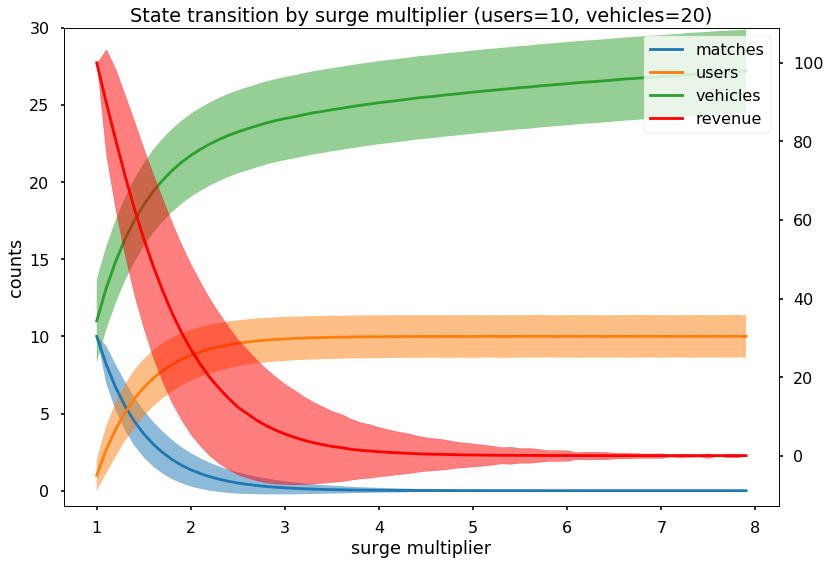

In [8]:
state = mdp.State(
    users=10,
    vehicles=20,
)
plot_transition(p, state)

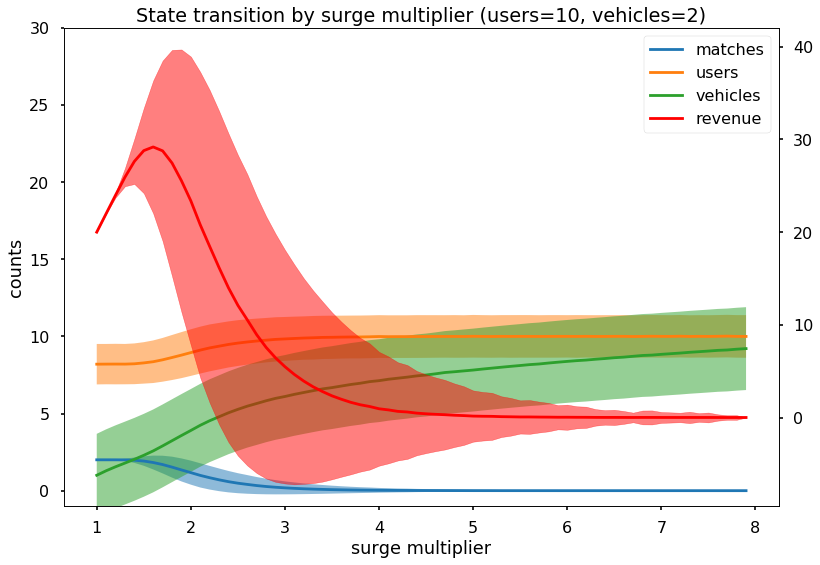

In [9]:
state = mdp.State(
    users=10,
    vehicles=2,
)
plot_transition(p, state)

In [10]:
tol = 0.5
n_samples = 1000
users_max = 10
vehicles_max = 10
v0 = np.random.uniform(0, 1, [vehicles_max, users_max])
p = mdp.Parameters(
    alpha=2.0,
    beta0=1.0,
    beta1=3.0,
    p_stay=0.9,
    demand_rate=1.0,
    base_cost=10.0,
    empty_cost=0.0,
    discount=0.98,
)
policy, values, policies, convergence = mdp.value_iteration(tol, v0, multipliers, p, n_samples)

iteration: 0
convergence distance: 1408.2448
iteration: 1
convergence distance: 116.2297
iteration: 2
convergence distance: 90.4968
iteration: 3
convergence distance: 86.2150
iteration: 4
convergence distance: 82.8672
iteration: 5
convergence distance: 79.1022
iteration: 6
convergence distance: 76.1517
iteration: 7
convergence distance: 72.4089
iteration: 8
convergence distance: 68.3263
iteration: 9
convergence distance: 65.5743
iteration: 10
convergence distance: 61.7115
iteration: 11
convergence distance: 57.1354
iteration: 12
convergence distance: 53.6852
iteration: 13
convergence distance: 50.2639
iteration: 14
convergence distance: 46.2676
iteration: 15
convergence distance: 42.5630
iteration: 16
convergence distance: 40.4305
iteration: 17
convergence distance: 39.2179
iteration: 18
convergence distance: 37.3939
iteration: 19
convergence distance: 35.8869
iteration: 20
convergence distance: 35.4844
iteration: 21
convergence distance: 34.5146
iteration: 22
convergence distance: 32.

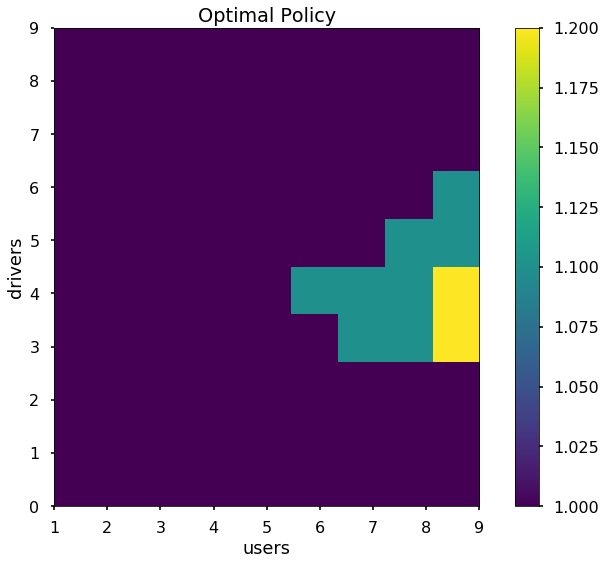

In [16]:
non_trivial_policy = policy[:, 1:] # we don't care when the demand is 0
plt.imshow(non_trivial_policy, aspect='equal', origin='lower', extent=[1, users_max-1, 0, vehicles_max-1])
plt.colorbar()
plt.title("Optimal Policy")
plt.xlabel("users")
plt.ylabel("drivers")
None

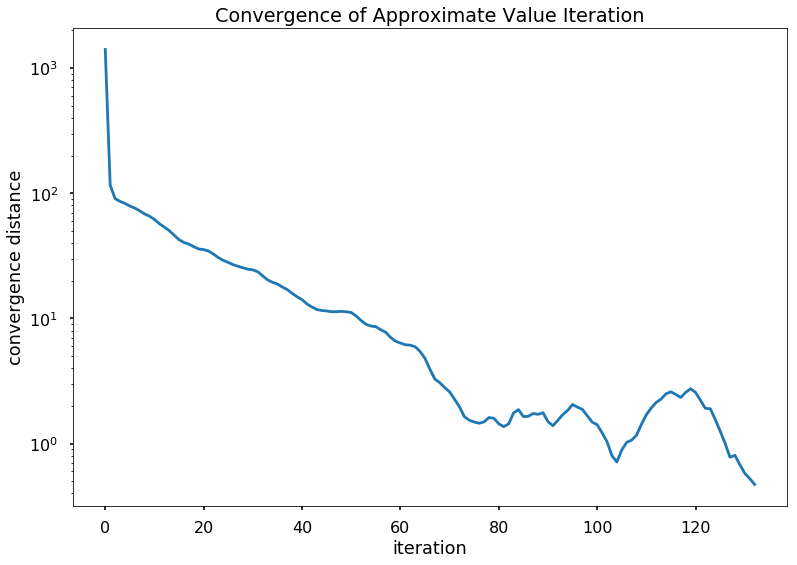

In [12]:
plt.semilogy(convergence)
plt.xlabel("iteration")
plt.ylabel("convergence distance")
plt.title("Convergence of Approximate Value Iteration")
None

In [18]:
tol = 0.5
n_samples = 1000
users_max = 10
vehicles_max = 10
v0 = np.random.uniform(0, 1, [vehicles_max, users_max])
p = mdp.Parameters(
    alpha=0.5,
    beta0=1.0,
    beta1=3.0,
    p_stay=0.9,
    demand_rate=1.0,
    base_cost=10.0,
    empty_cost=0.0,
    discount=0.98,
)
policy, values, policies, convergence = mdp.value_iteration(tol, v0, multipliers, p, n_samples)

iteration: 0
convergence distance: 2877.1735
iteration: 1
convergence distance: 972.8915
iteration: 2
convergence distance: 485.1204
iteration: 3
convergence distance: 355.9958
iteration: 4
convergence distance: 298.0520
iteration: 5
convergence distance: 263.7924
iteration: 6
convergence distance: 233.9459
iteration: 7
convergence distance: 209.0512
iteration: 8
convergence distance: 191.4466
iteration: 9
convergence distance: 180.6278
iteration: 10
convergence distance: 167.5416
iteration: 11
convergence distance: 156.9179
iteration: 12
convergence distance: 147.6058
iteration: 13
convergence distance: 140.3657
iteration: 14
convergence distance: 134.2364
iteration: 15
convergence distance: 127.0435
iteration: 16
convergence distance: 120.7403
iteration: 17
convergence distance: 115.2306
iteration: 18
convergence distance: 109.9346
iteration: 19
convergence distance: 104.3317
iteration: 20
convergence distance: 99.6345
iteration: 21
convergence distance: 95.6952
iteration: 22
converg

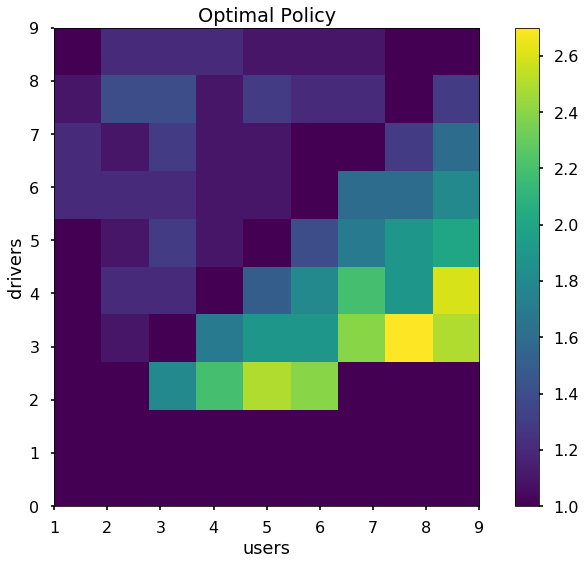

In [19]:
non_trivial_policy = policy[:, 1:] # we don't care when the demand is 0
plt.imshow(non_trivial_policy, aspect='equal', origin='lower', extent=[1, users_max-1, 0, vehicles_max-1])
plt.colorbar()
plt.title("Optimal Policy")
plt.xlabel("users")
plt.ylabel("drivers")
None

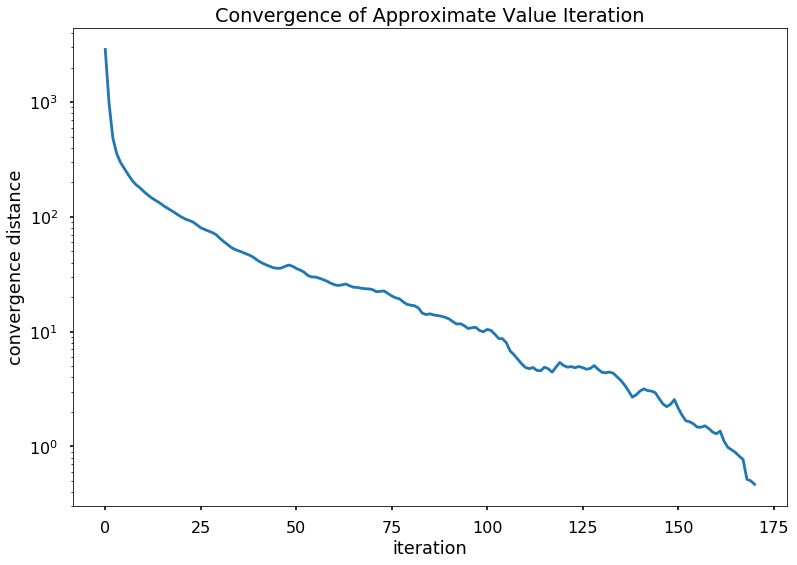

In [20]:
plt.semilogy(convergence)
plt.xlabel("iteration")
plt.ylabel("convergence distance")
plt.title("Convergence of Approximate Value Iteration")
None